In [7]:
import numpy as np
from UCB_discrete import UCB_discrete, UCB_os_gau, UCB_os_exp, UCB1_os, UCB_os_comb
from collections import defaultdict
import Environment
from Environment import AbsGau, Exp, Comb, AbsGau_Outlier, Exp_Outlier
from SimulatedGames import simulate
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt
import plots
import seaborn as sns
import pickle

%matplotlib inline

# UCB for order statistics

This notebook is designed to show the idea using order statistics to design UCB policies works empirically. The experiment is designed on simulated data, for two special reward distributions proved by [notes](https://github.com/chengsoonong/eheye/tree/master/writing/QuantUCB_orderstat): 

(1) Absolute value of center Gaussian rewards  
(2) Exponential rewards  
(3) Arbtrary distributions (combing 1 and 2)

For each case, we show the results for both estiamted parameter and true parameter.

Settings: 3 independent arms, 10000 rounds with 50 indepenent experiments. Evaluated by 
a. expected sub-optimal draws.
b. the percent of best arm selected. 

Policy (Empirical policy): In round t+1, select the arm with index, 
$$argmax_{i \in \mathcal{K}} \hat{m}_{i, T_i(t)} + \beta(\sqrt{2v_t \varepsilon} + 2 \varepsilon \sqrt{v_t/T_i(t)})$$

where $\hat{m}_{i, T_i(t)}$ is the empirical median for arm i at the round t, $\varepsilon = \alpha \log t$, $v_t$ depends on reward distributions. $T_i(t)$ is the number of times arm i has been played until round t. 

We fix the parameters $\alpha, \beta$ in this notebook, see [here](https://github.com/chengsoonong/eheye/blob/master/UCB/OS_UCB/ucb_os_hyperparameter_tuning_outliers_testing.ipynb) for experiments on tuning parameters, [here](https://github.com/chengsoonong/eheye/blob/master/UCB/OS_UCB/Variance_Sensitiveness_test.ipynb) for experiments test the policy senstivity for different variance of reward distribution, [here](https://github.com/chengsoonong/eheye/blob/master/UCB/OS_UCB/Sanity_test.ipynb) for some sanity test of our policy.  

In [2]:
# setting

num_rounds = 1000
num_exper = 100
num_arms = 3

# environment

'''
environments = {#AbsGau: [0.5, 1, 1.5], 
                #Exp: [2.0, 1, 3.0/2],
                #Comb: [0.7, 0.7, 1], 
                AbsGau_Outlier: [0.5, 1, 1.5],
                Exp_Outlier: [2.0, 1, 3.0/2]
               }
'''

Group_small = [
    {AbsGau: [0.5, 0.1, 1.5]}, 
    {Exp:    [2, 1, 1.5]},
    {AbsGau_Outlier: [0.5, 0.1, 1.5]},
    {Exp_Outlier: [2, 1, 1.5]},
    {AbsGau: [0.5], Exp: [1, 1.5]},
    {AbsGau_Outlier: [0.5], Exp_Outlier: [1, 1.5]},
]

Group_medium = [
    {AbsGau: [5, 10, 15]}, 
    {Exp:    [0.2, 0.10, 0.15]},
    {AbsGau_Outlier: [5, 10, 15]},
    {Exp_Outlier: [0.2, 0.10, 0.15]},
    {AbsGau: [5], Exp: [0.10, 0.15]},
    {AbsGau_Outlier: [5], Exp_Outlier: [0.10, 0.15]}
]

Group_big = [
    {AbsGau: [50, 100, 150]}, 
    {Exp:    [0.02, 0.010, 0.015]},
    {AbsGau_Outlier: [50, 100, 150]},
    {Exp_Outlier: [0.02, 0.010, 0.015]},
    {AbsGau: [50], Exp: [0.010, 0.015]},
    {AbsGau_Outlier: [50], Exp_Outlier: [0.010, 0.015]}
]

environments = Group_small + Group_medium + Group_big

rewards_env, medians, samples = Environment.setup_env(num_arms, environments)

# policy
'''
policy = {'AbsGau': UCB_discrete, #UCB_os_gau,
          'Exp': UCB_discrete, #UCB_os_exp,
          'Comb': UCB_discrete,     #UCB_os_comb,
          'AbsGau_Outlier': UCB_discrete, #UCB_os_gau
          'Exp_Outlier': UCB_discrete
         }
'''
policy = UCB_discrete

# hyper-parameters for policy

hyperpara_list = [[0.5, 0.2], [2, 0.5], [4, 1]]

evaluation = ['sd', 'r', 'bd']

In [4]:
# rewards_env
medians

defaultdict(list,
            {'AbsGau_[0.5, 0.1, 1.5]': [0.34286492009542274,
              0.06872977284757933,
              1.0021695143730414],
             'Exp_[2, 1, 1.5]': [0.348561312507073,
              0.6934087239453485,
              0.47215204647308495],
             'AbsGau_Outlier_[0.5, 0.1, 1.5]': [0.356438554725502,
              0.07259554754896894,
              1.0519999903484827],
             'Exp_Outlier_[2, 1, 1.5]': [0.3588819188267648,
              0.7423086726947103,
              0.49306905232294473],
             'AbsGau_[0.5]Exp_[1, 1.5]': [0.33227751064537164,
              0.6955944446162039,
              0.4572671326459201],
             'AbsGau_Outlier_[0.5]Exp_Outlier_[1, 1.5]': [0.35479203523093816,
              0.7301198703981306,
              0.4987718234903635],
             'AbsGau_[5, 10, 15]': [3.3972466233188143,
              6.75526944652643,
              10.24412238353711],
             'Exp_[0.2, 0.1, 0.15]': [3.477038272034134,
  

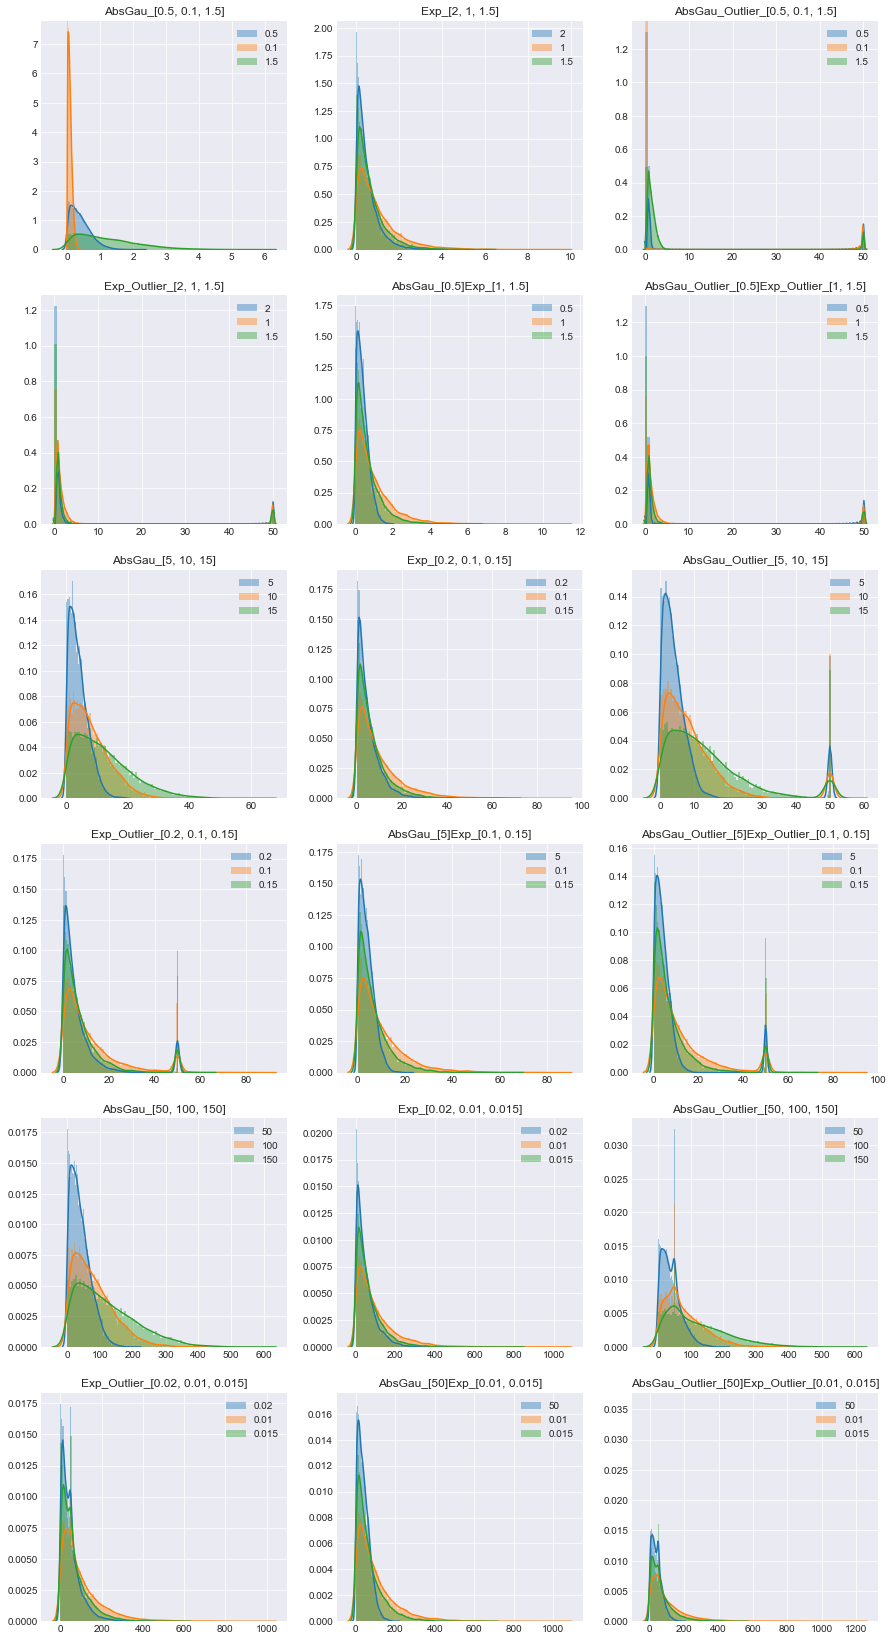

In [5]:
plots.plot_hist(samples)

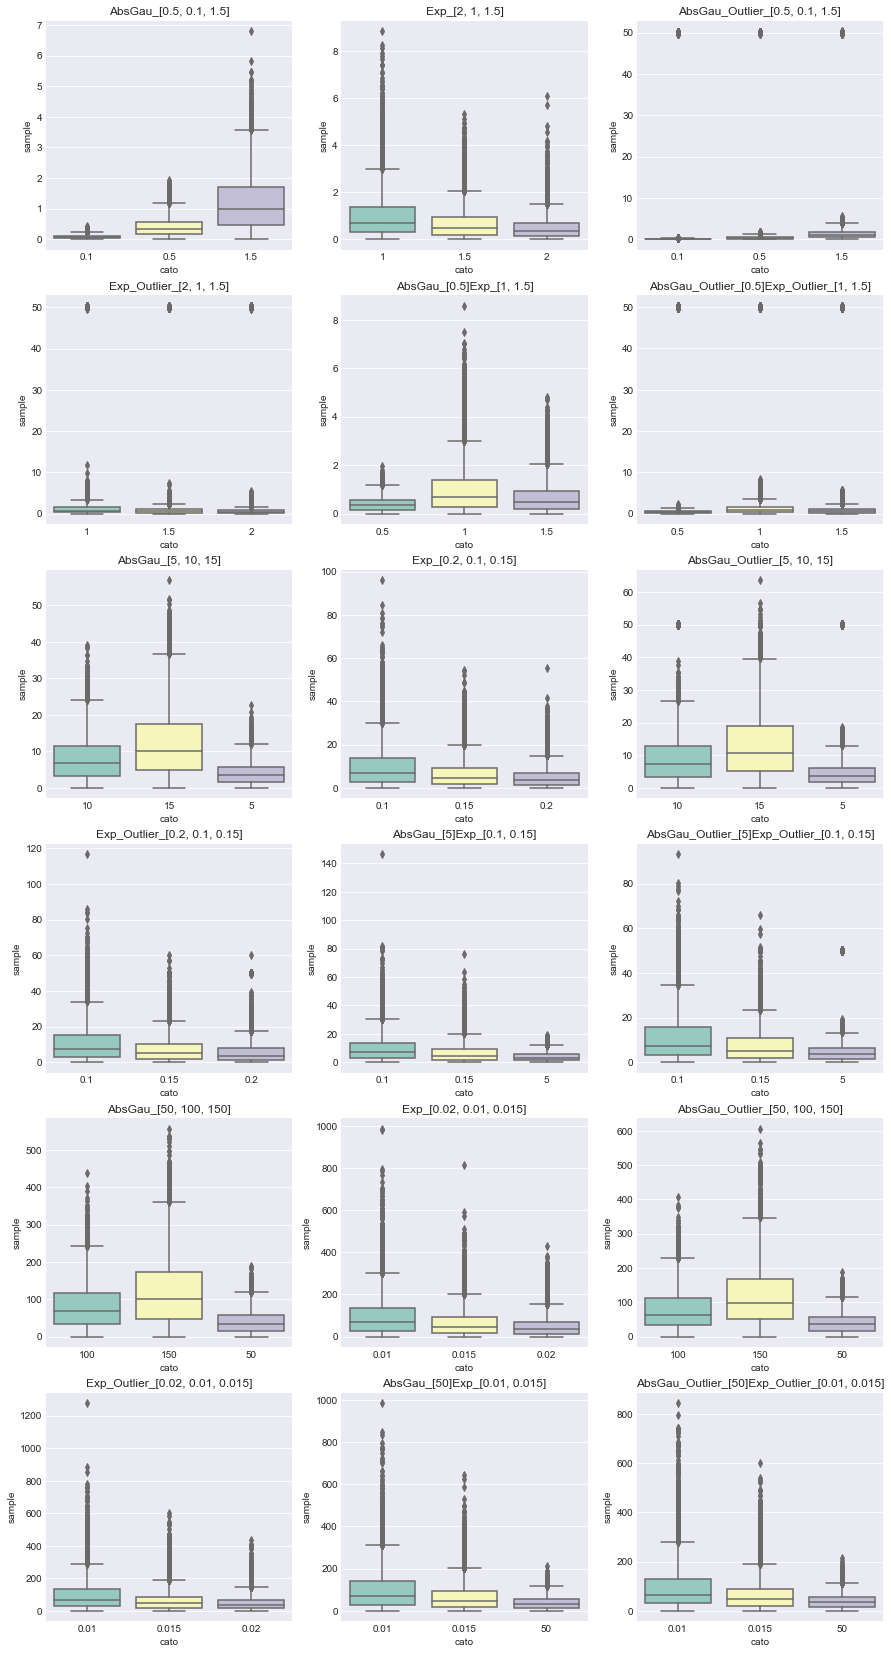

In [6]:
plots.plot_boxplot(samples)
#len(samples.keys())

In [ ]:
results = defaultdict(dict)

for key in rewards_env.keys():
    for hyperpara in hyperpara_list:
        for est_flag in [True, False]:
            name = key + '_' + str(num_exper) + '_' + str(num_rounds) 
            subname = str(est_flag)+ str(hyperpara)
            print(name + subname)
            p = IntProgress(max = num_exper)
            p.description = 'Running'
            display(p)
            results[name][subname], results[name]['bound']= \
                    simulate(rewards_env[key], medians[key], policy, num_exper, num_rounds, est_flag, hyperpara, evaluation, p)

In [ ]:
#with open('os_saving.pickle', 'rb') as handle:
#    b = pickle.load(handle)

In [ ]:

hyperpara_list = [[1], [5], [10]]
est_var = False

for key in rewards_env.keys():
    for hyperpara in hyperpara_list:
        name = key + '_' + str(num_exper) + '_' + str(num_rounds)
        subname = 'UCB1_' + str(hyperpara)
        print(name + subname)
        p = IntProgress(max = num_exper)
        p.description = 'Running'
        display(p)
        results[name][subname], bounds= simulate(rewards_env[key], medians[key], UCB1_os, num_exper, num_rounds, est_var, hyperpara, evaluation, p)
    


In [ ]:
 
saving = results

with open('os_saving_9.pickle', 'wb') as handle:
    pickle.dump(saving, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
with open('os_saving_9.pickle', 'rb') as handle:
    b = pickle.load(handle)

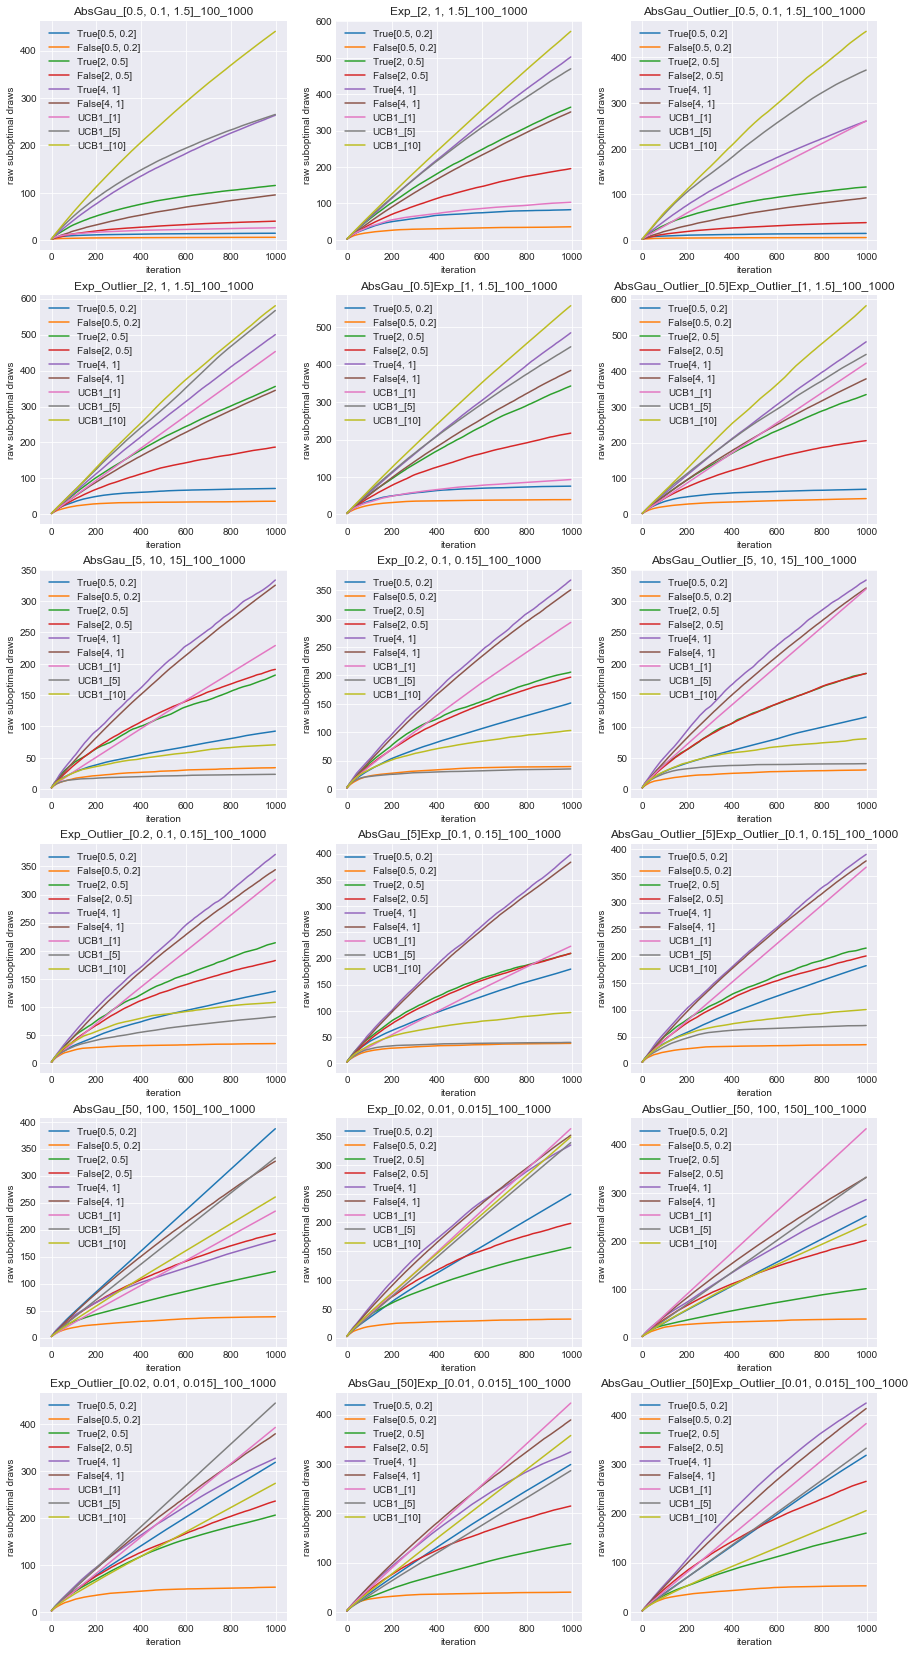

In [9]:
plots.plot_eva(b, 'sd', 'raw')